In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os

from xgboost import XGBRegressor
#import geopandas

In [2]:
# xgboost
import xgboost
#print("xgboost", xgboost.__version__)
print(sklearn.show_versions())


System:
    python: 3.9.0 (tags/v3.9.0:9cf6752, Oct  5 2020, 15:34:40) [MSC v.1927 64 bit (AMD64)]
executable: c:\users\abrinke\workspace\003_code\python\newyorkbikedata\venv\scripts\python.exe
   machine: Windows-10-10.0.17134-SP0

Python dependencies:
          pip: 20.2.4
   setuptools: 50.3.2
      sklearn: 0.23.2
        numpy: 1.19.4
        scipy: 1.5.4
       Cython: None
       pandas: 1.1.4
   matplotlib: 3.3.3
       joblib: 0.17.0
threadpoolctl: 2.1.0

Built with OpenMP: True
None


In [4]:
data = []

for file in os.scandir(r"C:\Users\ABRINKE\Workspace\003_Code\Python\NewYorkBikeData\Data\biketrips"):
    df = pd.read_csv(file)
    data.append(df)

newYorkTrip2019 = pd.concat(data)

In [5]:
newYorkTrip2019.shape

(20551697, 15)

In [6]:
newYorkTrip2019.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,320,2019-01-01 00:01:47.4010,2019-01-01 00:07:07.5810,3160.0,Central Park West & W 76 St,40.778968,-73.973747,3283.0,W 89 St & Columbus Ave,40.788221,-73.970416,15839,Subscriber,1971,1
1,316,2019-01-01 00:04:43.7360,2019-01-01 00:10:00.6080,519.0,Pershing Square North,40.751873,-73.977706,518.0,E 39 St & 2 Ave,40.747804,-73.973442,32723,Subscriber,1964,1
2,591,2019-01-01 00:06:03.9970,2019-01-01 00:15:55.4380,3171.0,Amsterdam Ave & W 82 St,40.785247,-73.976673,3154.0,E 77 St & 3 Ave,40.773142,-73.958562,27451,Subscriber,1987,1
3,2719,2019-01-01 00:07:03.5450,2019-01-01 00:52:22.6500,504.0,1 Ave & E 16 St,40.732219,-73.981656,3709.0,W 15 St & 6 Ave,40.738046,-73.996430,21579,Subscriber,1990,1
4,303,2019-01-01 00:07:35.9450,2019-01-01 00:12:39.5020,229.0,Great Jones St,40.727434,-73.993790,503.0,E 20 St & Park Ave,40.738274,-73.987520,35379,Subscriber,1979,1


In [7]:
newYorkTrip2019.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id           float64
start station name          object
start station latitude     float64
start station longitude    float64
end station id             float64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                   int64
gender                       int64
dtype: object

In [146]:
weather = pd.read_csv(r"C:\Users\ABRINKE\Workspace\003_Code\Python\NewYorkBikeData\Data\weather\WeatherNY.csv", sep=';')
weather['Date'] = pd.to_datetime(weather['Date'])

weather

,Date,Temperature,TemperatureMax,TemperatureMin,Rainfall
0,2020-01-01,1,5,-3,1.5
1,2020-02-01,1,5,-3,2.9
2,2020-03-01,1,5,-2,4.6
3,2020-04-01,1,5,-3,5.1
4,2020-05-01,1,5,-3,2.2
...,...,...,...,...,...
361,2020-12-27,3,6,-1,4.8
362,2020-12-28,3,7,-1,1.4
363,2020-12-29,2,6,-1,2.7
364,2020-12-30,2,5,-2,3.8


In [9]:
covid = pd.read_csv(r"C:\Users\ABRINKE\Workspace\003_Code\Python\NewYorkBikeData\Data\covid\COVID19_NYC.csv")

# EDA

In [9]:
#check for nulls
newYorkTrip2019.isnull().sum()

tripduration                 0
starttime                    0
stoptime                     0
start station id           180
start station name         180
start station latitude       0
start station longitude      0
end station id             180
end station name           180
end station latitude         0
end station longitude        0
bikeid                       0
usertype                     0
birth year                   0
gender                       0
dtype: int64

In [149]:
usertypes = newYorkTrip2019["usertype"].value_counts()
gender = newYorkTrip2019["gender"].value_counts().rename({0: "No information", 1: "Male", 2: "Female"})
birthyear = newYorkTrip2019["birth year"].value_counts()
birthyear = birthyear.loc[birthyear.index>1950]#.value_counts() #born after 1950
tripduration = newYorkTrip2019["tripduration"]
tripduration = tripduration[tripduration<14400]/60 #count only trips shorter than 4hours

(array([1.0960266e+07, 5.6010590e+06, 2.4599780e+06, 9.3765600e+05,
        3.0457800e+05, 1.0037400e+05, 4.8488000e+04, 3.0153000e+04,
        2.0476000e+04, 1.4087000e+04, 1.0660000e+04, 7.9170000e+03,
        6.0120000e+03, 4.7000000e+03, 3.8820000e+03, 3.3080000e+03,
        2.6430000e+03, 2.3280000e+03, 2.1760000e+03, 2.1330000e+03,
        1.6830000e+03, 1.3850000e+03, 1.2350000e+03, 9.7700000e+02]),
 array([  1.01666667,  10.97361111,  20.93055556,  30.8875    ,
         40.84444444,  50.80138889,  60.75833333,  70.71527778,
         80.67222222,  90.62916667, 100.58611111, 110.54305556,
        120.5       , 130.45694444, 140.41388889, 150.37083333,
        160.32777778, 170.28472222, 180.24166667, 190.19861111,
        200.15555556, 210.1125    , 220.06944444, 230.02638889,
        239.98333333]),
 <BarContainer object of 24 artists>)

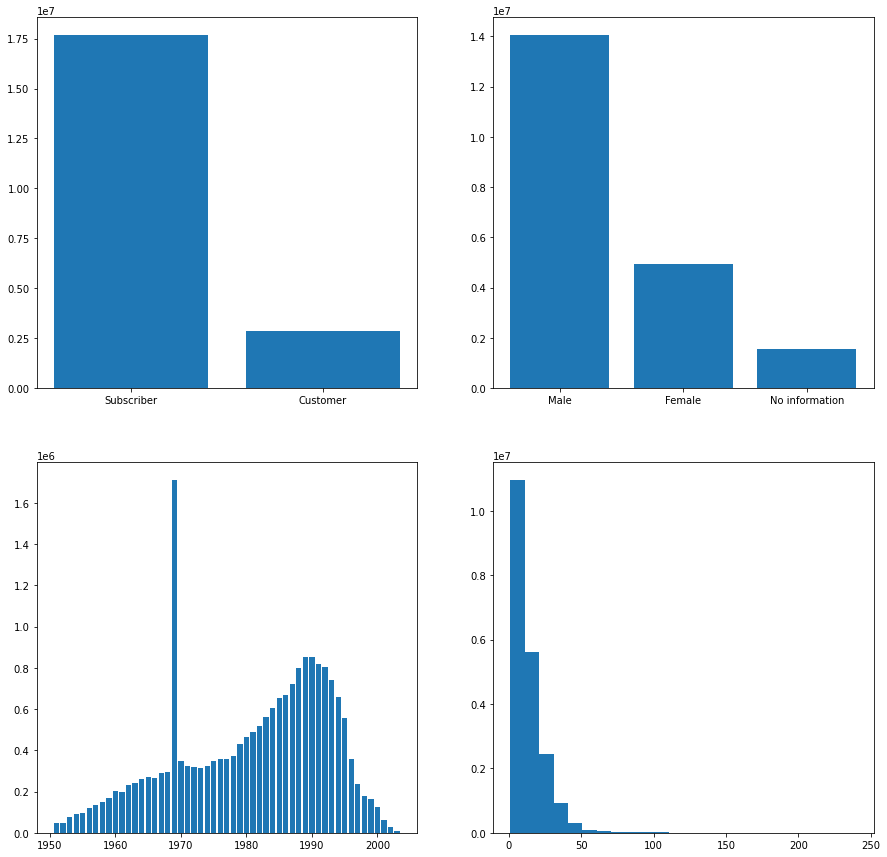

In [150]:
fig, ax = plt.subplots(2,2, figsize = (15,15))

ax[0,0].bar(usertypes.index, usertypes.values)
ax[0,1].bar(gender.index, gender.values)
ax[1,0].bar(birthyear.index, birthyear.values)
ax[1,1].hist(tripduration.values, bins = 24)

In [23]:
##image of filter

In [114]:
#filter data biirth year greater than 1950 and max trip duration 12h
newYorkTrip2019_filtered = newYorkTrip2019[(newYorkTrip2019['tripduration'] <=14400) & (newYorkTrip2019['birth year'] >=1950)]

In [116]:
#look at a single station
isStart = newYorkTrip2019_filtered['start station id'] ==3154
isEnd = newYorkTrip2019_filtered['end station id'] ==3154

station3154Start =newYorkTrip2019_filtered[isStart]
station3154End =newYorkTrip2019_filtered[isEnd]

#round starttime to full hour
station3154Start['timestamp'] = station3154Start['starttime'].astype('datetime64').round('H')
#reindex
station3154Start = station3154Start.set_index('timestamp')
station3154Start

<ipython-input-116-b9e3fb48d0ac>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station3154Start['timestamp'] = station3154Start['starttime'].astype('datetime64').round('H')


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
timestamp,,,,,,,,,,,,,,,
2019-01-01 10:00:00,198,2019-01-01 09:35:26.8890,2019-01-01 09:38:44.9410,3154.0,E 77 St & 3 Ave,40.773142,-73.958562,3375.0,3 Ave & E 72 St,40.769943,-73.960607,33671,Subscriber,1958,1
2019-01-01 12:00:00,847,2019-01-01 12:21:52.1120,2019-01-01 12:36:00.0070,3154.0,E 77 St & 3 Ave,40.773142,-73.958562,281.0,Grand Army Plaza & Central Park S,40.764397,-73.973715,34144,Subscriber,1987,2
2019-01-01 13:00:00,2246,2019-01-01 12:58:56.6150,2019-01-01 13:36:23.2130,3154.0,E 77 St & 3 Ave,40.773142,-73.958562,405.0,Washington St & Gansevoort St,40.739323,-74.008119,33330,Subscriber,1992,1
2019-01-01 14:00:00,1295,2019-01-01 13:30:11.7980,2019-01-01 13:51:47.4730,3154.0,E 77 St & 3 Ave,40.773142,-73.958562,459.0,W 20 St & 11 Ave,40.746745,-74.007756,35563,Subscriber,1987,1
2019-01-01 14:00:00,577,2019-01-01 13:42:23.8930,2019-01-01 13:52:01.5660,3154.0,E 77 St & 3 Ave,40.773142,-73.958562,3164.0,Columbus Ave & W 72 St,40.777057,-73.978985,27451,Subscriber,1968,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,1167,2019-12-31 19:18:24.2520,2019-12-31 19:37:51.8440,3154.0,E 77 St & 3 Ave,40.773142,-73.958562,3287.0,W 87 St & West End Ave,40.789622,-73.977570,40967,Customer,1969,0
2019-12-31 19:00:00,1231,2019-12-31 19:18:33.3160,2019-12-31 19:39:04.5590,3154.0,E 77 St & 3 Ave,40.773142,-73.958562,3287.0,W 87 St & West End Ave,40.789622,-73.977570,29055,Customer,1979,2
2019-12-31 20:00:00,262,2019-12-31 20:22:03.4130,2019-12-31 20:26:25.7620,3154.0,E 77 St & 3 Ave,40.773142,-73.958562,3372.0,E 74 St & 1 Ave,40.768974,-73.954823,16434,Subscriber,1995,2


In [118]:
df = station3154Start.groupby('timestamp').count().iloc[:, 0].rename('tripCount')
df

timestamp
2019-01-01 10:00:00    1
2019-01-01 12:00:00    1
2019-01-01 13:00:00    1
2019-01-01 14:00:00    4
2019-01-01 15:00:00    1
                      ..
2019-12-31 17:00:00    1
2019-12-31 18:00:00    1
2019-12-31 19:00:00    2
2019-12-31 20:00:00    2
2019-12-31 22:00:00    1
Name: tripCount, Length: 5775, dtype: int64

In [66]:
#create date df (date dimension)
dates = {'timestamp':pd.date_range(start='1/1/2019', end = '31/12/2019', freq='H')}

dateDf = pd.DataFrame(dates, columns = ['timestamp'])

dateDf['date'] = dateDf['timestamp'].dt.date
dateDf['year'] = dateDf['timestamp'].dt.year
dateDf['quarter'] = dateDf['timestamp'].dt.quarter
dateDf['month'] = dateDf['timestamp'].dt.month
dateDf['weekOfYear'] = dateDf['timestamp'].dt.weekofyear
dateDf['dayOfYear'] = dateDf['timestamp'].dt.dayofyear
dateDf['dayOfMonth'] = dateDf['timestamp'].dt.day
dateDf['hourOfDay'] = dateDf['timestamp'].dt.hour
#create isWeekday flag 1-5 for Monady through Friday 0 for weekend
dateDf['isWeekDay'] = dateDf['timestamp'] .dt.dayofweek < 5

dateDf.set_index('timestamp')

<ipython-input-66-79fa46c57045>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dateDf['weekOfYear'] = dateDf['timestamp'].dt.weekofyear


,date,year,quarter,month,weekOfYear,dayOfYear,dayOfMonth,hourOfDay,isWeekDay
timestamp,,,,,,,,,
2019-01-01 00:00:00,2019-01-01,2019,1,1,1,1,1,0,True
2019-01-01 01:00:00,2019-01-01,2019,1,1,1,1,1,1,True
2019-01-01 02:00:00,2019-01-01,2019,1,1,1,1,1,2,True
2019-01-01 03:00:00,2019-01-01,2019,1,1,1,1,1,3,True
2019-01-01 04:00:00,2019-01-01,2019,1,1,1,1,1,4,True
...,...,...,...,...,...,...,...,...,...
2019-12-30 20:00:00,2019-12-30,2019,4,12,1,364,30,20,True
2019-12-30 21:00:00,2019-12-30,2019,4,12,1,364,30,21,True
2019-12-30 22:00:00,2019-12-30,2019,4,12,1,364,30,22,True


In [131]:
resDf = dateDf.join(df, on = 'timestamp', how='left')
resDf['tripCount'] = resDf['tripCount'].fillna(0)
resDf

,timestamp,date,year,quarter,month,weekOfYear,dayOfYear,dayOfMonth,hourOfDay,isWeekDay,tripCount
0,2019-01-01 00:00:00,2019-01-01,2019,1,1,1,1,1,0,True,0.0
1,2019-01-01 01:00:00,2019-01-01,2019,1,1,1,1,1,1,True,0.0
2,2019-01-01 02:00:00,2019-01-01,2019,1,1,1,1,1,2,True,0.0
3,2019-01-01 03:00:00,2019-01-01,2019,1,1,1,1,1,3,True,0.0
4,2019-01-01 04:00:00,2019-01-01,2019,1,1,1,1,1,4,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...
8732,2019-12-30 20:00:00,2019-12-30,2019,4,12,1,364,30,20,True,4.0
8733,2019-12-30 21:00:00,2019-12-30,2019,4,12,1,364,30,21,True,1.0
8734,2019-12-30 22:00:00,2019-12-30,2019,4,12,1,364,30,22,True,0.0
8735,2019-12-30 23:00:00,2019-12-30,2019,4,12,1,364,30,23,True,1.0


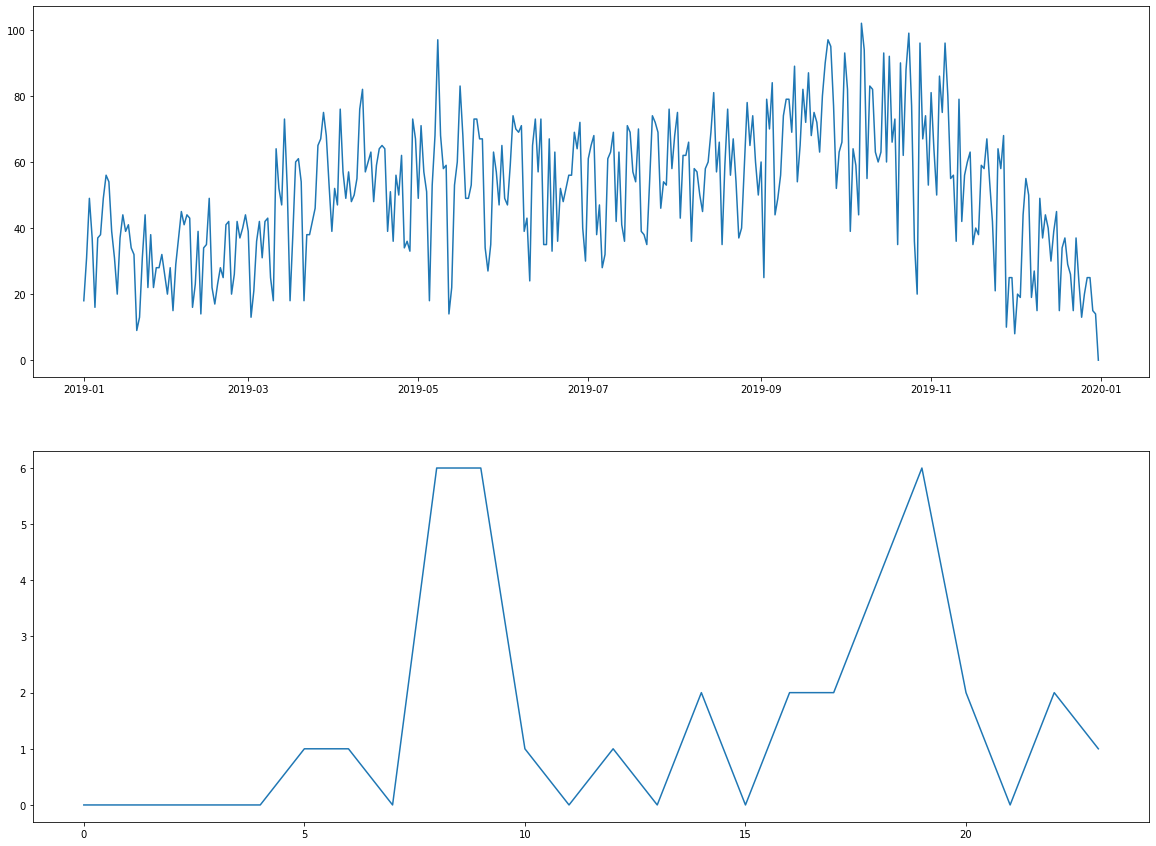

In [136]:
fig, ax = plt.subplots(2,1,figsize = (20,15))

#aggregated to tripcounts per day
ax[0].plot(resDf.groupby('date').sum('tripCount').index, resDf.groupby('date').sum('tripCount')['tripCount'].values)

#tripcounts for a single day
ax[1].plot(resDf['hourOfDay'][72:96], resDf['tripCount'][72:96])

In [95]:
rel_features = ['year','quarter','month','weekOfYear', 'dayOfYear', 'dayOfMonth', 'hourOfDay', 'isWeekDay']

In [96]:
train_x = resDf[rel_features]
train_y = resDf['tripCount']

In [97]:
display(train_x)
print(train_y)

,year,quarter,month,weekOfYear,dayOfYear,dayOfMonth,hourOfDay,isWeekDay
0,2019,1,1,1,1,1,0,True
1,2019,1,1,1,1,1,1,True
2,2019,1,1,1,1,1,2,True
3,2019,1,1,1,1,1,3,True
4,2019,1,1,1,1,1,4,True
...,...,...,...,...,...,...,...,...
8732,2019,4,12,1,364,30,20,True
8733,2019,4,12,1,364,30,21,True
8734,2019,4,12,1,364,30,22,True
8735,2019,4,12,1,364,30,23,True


0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8732    4.0
8733    1.0
8734    0.0
8735    1.0
8736    0.0
Name: tripCount, Length: 8737, dtype: float64


In [98]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [99]:
model.fit(train_x,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=3,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [143]:
test = pd.DataFrame(np.array([[2020,1,1,2,6,6,8,1]]),
                   columns = rel_features)
test

,year,quarter,month,weekOfYear,dayOfYear,dayOfMonth,hourOfDay,isWeekDay
0,2020,1,1,2,6,6,8,1


In [144]:
model.predict(test)

array([4.9680376], dtype=float32)

In [ ]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values